# Micrograd
**Link**: https://github.com/karpathy/micrograd

1. Micrograd is an autograd (automatic gradient) engine i.e. it implements backpropagation.
2. **Backpropagation**: efficiently calculates the gradient of a loss function, with respect to the parameters of a neural network. This allows us to iteratively tune the parameters of the neural network to minimize the loss function and thereby improve the accuracy of the network.
3. Micrograd allows us to build mathematical expressions as compute graphs. Imagine a compute graph with `x1`, `w1`, and `w0` nodes as input values. Say, the parent layer node `w1x1` is a multiplication (`*`) operator that calculates and stores the product of `x1` and `w1`. The grandparent layer `s` is an addition operator (`+`) that sums the values in the nodes `w1x1` and `w0`. This compute graph represents a _weighted linear combination_ ($s=w_1\cdot x_1+w_0$).
    1. Forward pass value of node `s` is stored in the `s.data` variable.
    2. Run backpropagation starting at node `s` using the `s.backward()` method, which applies the chain rule from calculus, i.e. the derivative of `s` with respect to each internal node and inputs (`s`, `w1x1`, `x1`, `w1`, and `w0`).
    3. The backward pass values, i.e. the gradients, are stored in `v.grad` e.g., `w1.grad` ($\frac{ds}{dw_1}$). The gradient tells us how `w1` affects `s` i.e., if we slightly increment `w1`, how much would `s` change by?
        * $\frac{ds}{ds} = 1$; trivial and irrelevant for training neural networks.
        * $\frac{ds}{dx_1}$; derivative of the loss function w.r.t. the data is not useful for training neural networks because the data is fixed.
        * $\frac{ds}{dw_0}$, $\frac{ds}{dw_1}$; derivatives of the loss function w.r.t. the weights is useful for training neural networks because the weights can be tuned.
4. "Micrograd is all you need" to train neural networks. Everything else given by frameworks such as Torch and JAX is just computational efficiency.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

## Derivative

$$
L = \lim_{h \rightarrow 0} \frac{f(x + h) - f(x)}{h}
$$

### Univariate function

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

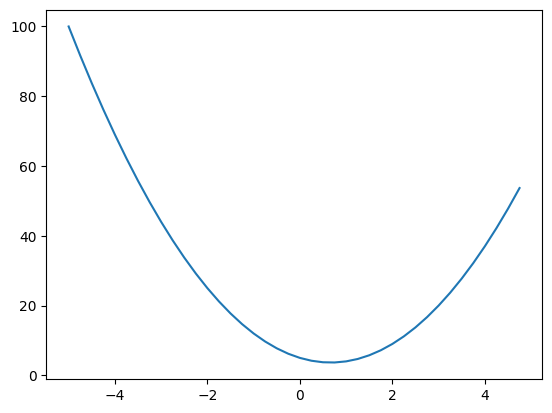

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 1e-6
x = 3.0

print(f"f(x): { f(x) }")
print(f"f(x + h): { f(x + h) }")
print(f"df(x)/dx: { (f(x + h) - f(x)) / h }")
print(f"6x - 4: { 6*x - 4 }")

f(x): 20.0
f(x + h): 20.000014000003002
df(x)/dx: 14.000003002223593
6x - 4: 14.0


### Multivariate function

In [6]:
def g(a, b, c):
    return a * b + c

In [7]:
h = 1e-6
w1, x1, w0 = 2.0, -3.0, 10.0

print(f"g(w1, x1, w0): { g(w1, x1, w0) }")
print(f"g(w1 + h, x1, w0): { g(w1 + h, x1, w0)}")
print(f"dg(w1, x1, w0)/da: { (g(w1 + h, x1, w0) - g(w1, x1, w0)) / h }")
print(f"b: { x1 }")

g(w1, x1, w0): 4.0
g(w1 + h, x1, w0): 3.9999969999999996
dg(w1, x1, w0)/da: -3.000000000419334
b: -3.0


In [8]:
h = 1e-6
w1, x1, w0 = 2.0, -3.0, 10.0

print(f"d(w1, x1, w0): { g(w1, x1, w0) }")
print(f"d(w1, x1 + h, w0): { g(w1, x1 + h, w0) }")
print(f"dg(w1, x1, w0)/db: { (g(w1, x1 + h, w0) - g(w1, x1, w0)) / h }")
print(f"a: { w1 }")

d(w1, x1, w0): 4.0
d(w1, x1 + h, w0): 4.000002
dg(w1, x1, w0)/db: 2.000000000279556
a: 2.0


In [9]:
h = 1e-6
w1, x1, w0 = 2.0, -3.0, 10.0

print(f"g(w1, x1, w0): { g(w1, x1, w0) }")
print(f"g(w1, x1, w0 + h): { g(w1, x1, w0 + h) }")
print(f"dg(w1, x1, w0)/dc: { (g(w1, x1, w0 + h) - g(w1, x1, w0)) / h }")
print(f"1: { 1 }")

g(w1, x1, w0): 4.0
g(w1, x1, w0 + h): 4.000000999999999
dg(w1, x1, w0)/dc: 0.9999999992515995
1: 1


## Building mathematical expressions

1. The main thing to remember when implementing an operator for the `Value` object is that we know how to compute the local derivative (gradient of the function w.r.t. to each children) of the operator. Otherwise, the operator can be at any level of abstraction (exponent, addition, subtraction, division vs. tanh directly).

In [10]:
from micrograd.engine import Value

In [23]:
w1 = Value(2.0, label='w1')
x1 = Value(-3.0, label='x1')
w0 = Value(10.0, label='w0')
w1x1 = w1 * x1; w1x1.label = 'x1w1'
s = w1x1 + w0; s.label = 's'
print(s)

Value(data=4.0)


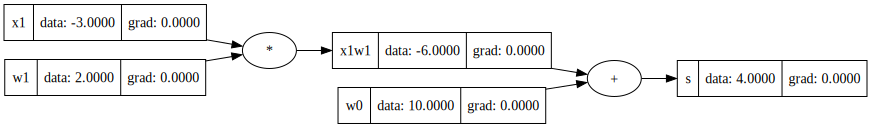

In [24]:
s.plot()

### Manual gradient calculation

Using the chain rule in calculus—
* $\frac{ds}{ds} = 1$: trivial case.
* $s = w_1x_1 + x_0$: linear combination formula.
    * $\frac{ds}{dw1x1} = 1$: if you increment a summation term by some amount, the overall sum will increase by the same amount.
    * $\frac{ds}{dw_0} = 1$: same as above.
    * $\frac{ds}{dx_1} = \frac{ds}{dw1x1}\cdot\frac{w1x1}{dx_1} = 1\cdot w_1$: if I increase $x_1$ by a small amount, it will proportionally add $w_1$ to the overall output.
    * $\frac{ds}{dw_1} = \frac{ds}{dw1x1}\cdot\frac{w1x1}{dw_1} = 1\cdot x_1$: if I increase $w_1$ by a small amount, it will proportionally add $x_1$ to the overall output.

In summary,
* **Addition**: multiply the parent's gradient by 1.
* **Multiplication**: each child borrows the data value from its sibling and multiplies it with the parent's gradient.


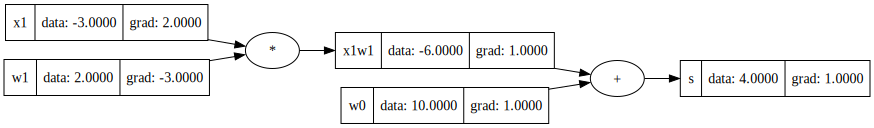

In [25]:
s.grad = 1
w1x1.grad = 1
w0.grad = 1
x1.grad = w1.data
w1.grad = x1.data

s.plot()

### Automated gradient calculation

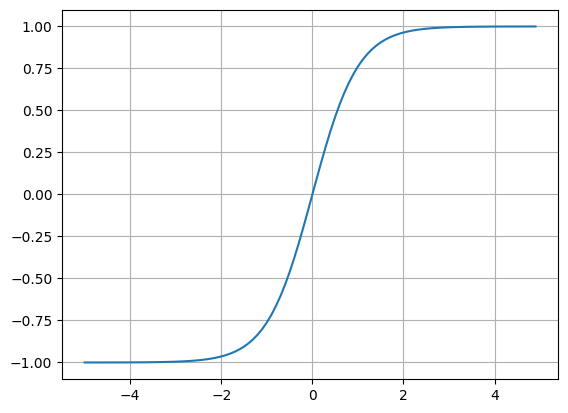

In [27]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1))); plt.grid()